# **GRU (GATED RECURRENT UNIT)**
## What are GRUs?

A Gated Recurrent Unit (GRU), as its name suggests, is a variant of the RNN architecture, and uses gating mechanisms to control and manage the flow of information between cells in the neural network. GRUs were introduced only in 2014 by Cho, et al. and can be considered a relatively new architecture, especially when compared to the widely-adopted LSTM, which was proposed in 1997 by Sepp Hochreiter and Jürgen Schmidhuber.

<p align="center">
  <img width="500" height="350" src="https://miro.medium.com/max/875/1*jhi5uOm9PvZfmxvfaCektw.png">
</p>

## What are LSTMs?
Long Short-Term Memory (LSTM) networks are a type of recurrent neural network capable of learning order dependence in sequence prediction problems.
This is a behavior required in complex problem domains like machine translation, speech recognition, and more.
<p align="center">
  <img width="550" height="350" src="https://miro.medium.com/max/875/1*0f8r3Vd-i4ueYND1CUrhMA.png">
</p>

## GRU IMPLEMENTATION
* The structure of the GRU allows it to adaptively capture dependencies from large sequences of data without discarding information from earlier parts of the sequence. This is achieved through its gating units, similar to the ones in LSTMs, which solve the vanishing/exploding gradient problem of traditional RNNs. These gates are responsible for regulating the information to be kept or discarded at each time step. 

* We’ll be implementing a GRU model in code. To further our GRU-LSTM comparison, we’ll also be using an LSTM model to complete the same task. We’ll evaluate the performance of both models on a few metrics. The dataset that we will be using is the Hourly Energy Consumption dataset, which can be found on [Kaggle](https://www.kaggle.com/robikscube/hourly-energy-consumption). The dataset contains power consumption data across different regions around the United States recorded on an hourly basis.



We will be using the PyTorch library to implement both types of models along with other common Python libraries used in data analytics.

In [ ]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from tqdm import tqdm_notebook
from sklearn.preprocessing import MinMaxScaler

# Define data root directory
data_dir = "/content/sample_data"
print(os.listdir(data_dir))


['anscombe.json', 'README.md', 'california_housing_train.csv', 'california_housing_test.csv', 'mnist_train_small.csv', 'mnist_test.csv']


In [ ]:
# Visualise how our data looks
pd.read_csv("/content/AEP_hourly.csv").head()

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


**DATA PREPROCESSING**
* After visualizing the dataset, we need to preprocess the data in order to filter out the files that are not being used.
* The data for each time is generalized.
* To help the algorithm work faster, we scale the data to similar values; 0 and 1.
* Also, we need to split the inputs and labels into training and test sets.


In [ ]:
# The scaler objects will be stored in this dictionary so that our output test data from the model can be re-scaled during evaluation
label_scalers = {}

train_x = []
test_x = {}
test_y = {}

for file in tqdm_notebook(os.listdir(data_dir)): 
    # Skipping the files we're not using
    if file[-4:] != ".csv" or file == "pjm_hourly_est.csv":
        continue
    
    # Store csv file in a Pandas DataFrame
    df = pd.read_csv("/content/AEP_hourly.csv", parse_dates=[0])
    # Processing the time data into suitable input formats
    df['hour'] = df.apply(lambda x: x['Datetime'].hour,axis=1)
    df['dayofweek'] = df.apply(lambda x: x['Datetime'].dayofweek,axis=1)
    df['month'] = df.apply(lambda x: x['Datetime'].month,axis=1)
    df['dayofyear'] = df.apply(lambda x: x['Datetime'].dayofyear,axis=1)
    df = df.sort_values("Datetime").drop("Datetime",axis=1)
    
    # Scaling the input data
    sc = MinMaxScaler()
    label_sc = MinMaxScaler()
    data = sc.fit_transform(df.values)
    # Obtaining the Scale for the labels(usage data) so that output can be re-scaled to actual value during evaluation
    label_sc.fit(df.iloc[:,0].values.reshape(-1,1))
    label_scalers[file] = label_sc
    
    # Define lookback period and split inputs/labels
    lookback = 90
    inputs = np.zeros((len(data)-lookback,lookback,df.shape[1]))
    labels = np.zeros(len(data)-lookback)
    
    for i in range(lookback, len(data)):
        inputs[i-lookback] = data[i-lookback:i]
        labels[i-lookback] = data[i,0]
    inputs = inputs.reshape(-1,lookback,df.shape[1])
    labels = labels.reshape(-1,1)
    
    # Split data into train/test portions and combining all data from different files into a single array
    test_portion = int(0.1*len(inputs))
    if len(train_x) == 0:
        train_x = inputs[:-test_portion]
        train_y = labels[:-test_portion]
    else:
        train_x = np.concatenate((train_x,inputs[:-test_portion]))
        train_y = np.concatenate((train_y,labels[:-test_portion]))
    test_x[file] = (inputs[-test_portion:])
    test_y[file] = (labels[-test_portion:])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
print(train_x.shape)

(436260, 90, 5)


We have a total of 4,36,260 sequences of training data.

To improve the speed of our training, we will now process the data in batches so that the model doesn’t need to update its weights as frequently. The Torch Dataset and DataLoader classes are useful for splitting our data into batches and shuffling them.

**NOTE**: The batch size should be chosen in accordance with the number of sequences. Else, the training time of epochs will be quite high.

In [ ]:
batch_size = 660
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)

Since we will be dealing with an ample number of epochs, we must check if we can use any GPU to speed up the training time.

In [ ]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In the next step, we define the structure of the models i.e, the GRU and the LSTM models respectively. 

In [ ]:

class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x, h):
        out, h = self.gru(x, h)
        out = self.fc(self.relu(out[:,-1]))
        return out, h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return hidden

class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(LSTMNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x, h):
        out, h = self.lstm(x, h)
        out = self.fc(self.relu(out[:,-1]))
        return out, h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

* The training process is defined in a function below so that we can reproduce it for both models. Both models will have the same number of dimensions in the hidden state and layers, trained over the same number of epochs and learning rate, and trained and tested on the exact same set of data.

* For our accuracy measure, we'll use Symmetric Mean Absolute Percentage Error (sMAPE) to evaluate the models. sMAPE is the sum of the absolute difference between the predicted and actual values divided by the average of the predicted and actual value, therefore giving a percentage measuring the amount of error.This is the formula for sMAPE:

<p align="center">
  <img width="450" height="125" src="https://vedexcel.com/wp-content/uploads/2020/12/SMAPE_Python.png?ezimgfmt=ng:webp/ngcb2">
</p>

In [ ]:

def train(train_loader, learn_rate, hidden_dim=256, EPOCHS=5, model_type="GRU"):
    
    # Setting common hyperparameters
    input_dim = next(iter(train_loader))[0].shape[2]
    output_dim = 1
    n_layers = 2
    # Instantiating the models
    if model_type == "GRU":
        model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)
    else:
        model = LSTMNet(input_dim, hidden_dim, output_dim, n_layers)
    model.to(device)
    
    # Defining loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
    
    model.train()
    print("Starting Training of {} model".format(model_type))
    epoch_times = []
    # Start training loop
    for epoch in range(1,EPOCHS+1):
        start_time = time.clock()
        h = model.init_hidden(batch_size)
        avg_loss = 0.
        counter = 0
        for x, label in train_loader:
            counter += 1
            if model_type == "GRU":
                h = h.data
            else:
                h = tuple([e.data for e in h])
            model.zero_grad()
            
            out, h = model(x.to(device).float(), h)
            loss = criterion(out, label.to(device).float())
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            if counter%200 == 0:
                print("Epoch {}......Step: {}/{}....... Average Loss for Epoch: {}".format(epoch, counter, len(train_loader), avg_loss/counter))
        current_time = time.clock()
        print("Epoch {}/{} Done, Total Loss: {}".format(epoch, EPOCHS, avg_loss/len(train_loader)))
        print("Time Elapsed for Epoch: {} seconds".format(str(current_time-start_time)))
        epoch_times.append(current_time-start_time)
    print("Total Training Time: {} seconds".format(str(sum(epoch_times))))
    return model

def evaluate(model, test_x, test_y, label_scalers):
    model.eval()
    outputs = []
    targets = []
    start_time = time.clock()
    for i in test_x.keys():
        inp = torch.from_numpy(np.array(test_x[i]))
        labs = torch.from_numpy(np.array(test_y[i]))
        h = model.init_hidden(inp.shape[0])
        out, h = model(inp.to(device).float(), h)
        outputs.append(label_scalers[i].inverse_transform(out.cpu().detach().numpy()).reshape(-1))
        targets.append(label_scalers[i].inverse_transform(labs.numpy()).reshape(-1))
    print("Evaluation Time: {}".format(str(time.clock()-start_time)))
    sMAPE = 0
    for i in range(len(outputs)):
        sMAPE += np.mean(abs(outputs[i]-targets[i])/(targets[i]+outputs[i])/2)/len(outputs)
    print("sMAPE: {}%".format(sMAPE*100))
    return outputs, targets, sMAPE

In [ ]:
lr = 0.001
gru_model = train(train_loader, lr, model_type="GRU")

Starting Training of GRU model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Epoch 1......Step: 200/661....... Average Loss for Epoch: 0.005267100058554206
Epoch 1......Step: 400/661....... Average Loss for Epoch: 0.0029989119542733534
Epoch 1......Step: 600/661....... Average Loss for Epoch: 0.002134808835883935


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Epoch 1/5 Done, Total Loss: 0.00196983792716757
Time Elapsed for Epoch: 130.567195 seconds
Epoch 2......Step: 200/661....... Average Loss for Epoch: 0.00029219337840913795
Epoch 2......Step: 400/661....... Average Loss for Epoch: 0.00025876856485410824
Epoch 2......Step: 600/661....... Average Loss for Epoch: 0.00024400176465860568
Epoch 2/5 Done, Total Loss: 0.0002423938608245076
Time Elapsed for Epoch: 130.14596400000002 seconds
Epoch 3......Step: 200/661....... Average Loss for Epoch: 0.0001921667539863847
Epoch 3......Step: 400/661....... Average Loss for Epoch: 0.00018467722315108404
Epoch 3......Step: 600/661....... Average Loss for Epoch: 0.00017461122160360295
Epoch 3/5 Done, Total Loss: 0.00017432108345649694
Time Elapsed for Epoch: 130.33189500000003 seconds
Epoch 4......Step: 200/661....... Average Loss for Epoch: 0.0001450536241827649
Epoch 4......Step: 400/661....... Average Loss for Epoch: 0.00014836333895800635
Epoch 4......Step: 600/661....... Average Loss for Epoch: 0.

In [ ]:
lstm_model = train(train_loader, lr, model_type="LSTM")

Starting Training of LSTM model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Epoch 1......Step: 200/661....... Average Loss for Epoch: 0.01064844386652112
Epoch 1......Step: 400/661....... Average Loss for Epoch: 0.005929349538055248
Epoch 1......Step: 600/661....... Average Loss for Epoch: 0.004152223642837877


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Epoch 1/5 Done, Total Loss: 0.0038072286540383133
Time Elapsed for Epoch: 153.90197899999998 seconds
Epoch 2......Step: 200/661....... Average Loss for Epoch: 0.000378080916707404
Epoch 2......Step: 400/661....... Average Loss for Epoch: 0.000346849267007201
Epoch 2......Step: 600/661....... Average Loss for Epoch: 0.00031683717451718016
Epoch 2/5 Done, Total Loss: 0.000307627472297025
Time Elapsed for Epoch: 153.8819709999999 seconds
Epoch 3......Step: 200/661....... Average Loss for Epoch: 0.00020913312255288474
Epoch 3......Step: 400/661....... Average Loss for Epoch: 0.0002008124304120429
Epoch 3......Step: 600/661....... Average Loss for Epoch: 0.00019844726911590746
Epoch 3/5 Done, Total Loss: 0.00019585947001898174
Time Elapsed for Epoch: 153.9817079999999 seconds
Epoch 4......Step: 200/661....... Average Loss for Epoch: 0.00015975742189766606
Epoch 4......Step: 400/661....... Average Loss for Epoch: 0.00015967646333592711
Epoch 4......Step: 600/661....... Average Loss for Epoch

We will now use the evaluate() function to fetch the accuracy of both the models

In [ ]:
gru_outputs, targets, gru_sMAPE = evaluate(gru_model, test_x, test_y, label_scalers)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Evaluation Time: 3.1644410000001244
sMAPE: 0.19441486298881558%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [ ]:
lstm_outputs, targets, lstm_sMAPE = evaluate(lstm_model, test_x, test_y, label_scalers)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Evaluation Time: 4.194827000000032
sMAPE: 0.18440479951751307%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


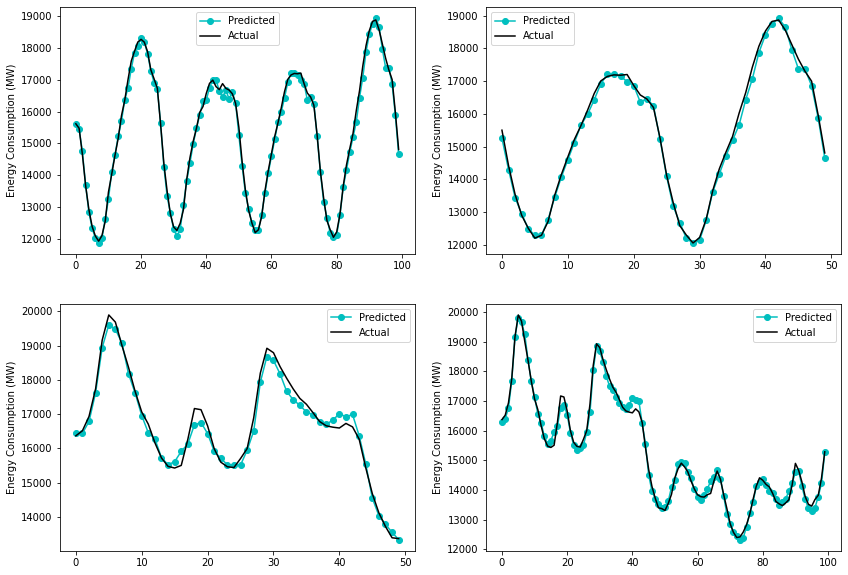

In [ ]:
plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
plt.plot(gru_outputs[0][-100:], "-o", color="c", label="Predicted")
plt.plot(targets[0][-100:], color="k", label="Actual")
plt.ylabel('Energy Consumption (MW)')
plt.legend()

plt.subplot(2,2,2)
plt.plot(gru_outputs[1][-50:], "-o", color="c", label="Predicted")
plt.plot(targets[1][-50:], color="k", label="Actual")
plt.ylabel('Energy Consumption (MW)')
plt.legend()

plt.subplot(2,2,3)
plt.plot(gru_outputs[2][:50], "-o", color="c", label="Predicted")
plt.plot(targets[2][:50], color="k", label="Actual")
plt.ylabel('Energy Consumption (MW)')
plt.legend()

plt.subplot(2,2,4)
plt.plot(lstm_outputs[3][:100], "-o", color="c", label="Predicted")
plt.plot(targets[3][:100], color="k", label="Actual")
plt.ylabel('Energy Consumption (MW)')
plt.legend()
plt.show()